# Cambridge-Driving Labeled Video Database (CamVid)

In [1]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [2]:
import utils

In [3]:
class CamVid(torch.utils.data.Dataset):
    """
    CamVid dataset from https://github.com/alexgkendall/SegNet-Tutorial/tree/master/CamVid/
    """
    
    # training dataset root directories
    train_dir = 'train'
    train_label_dir = 'trainannot'
    
    # validation dataset root directories
    valid_dir = 'val'
    valid_label_dir = 'valannot'
    
    # test dataset root directories
    test_dir = 'test'
    test_label_dir = 'testannot'
    
    # images extension
    img_extension = '.png'
    
    # default encoding for pixel value, class name and class color
    from collections import OrderedDict
    
    color_encoding = OrderedDict([
        ('sky', (128, 128, 128)), # RGB format
        ('building', (128, 0, 0)),
        ('pole', (192, 192, 128)),
        ('road_marking', (255, 69, 0)),
        ('road', (128, 64, 128)),
        ('pavement', (60, 40, 222)),
        ('tree', (128, 128, 0)),
        ('sign_symbol', (192, 128, 128)),
        ('fence', (64, 64, 128)),
        ('car', (64, 0, 128)),
        ('pedestrian', (64, 64, 0)),
        ('bicyclist', (0, 128, 192)),
        ('unlabeled', (0, 0, 0))
    ])
    
    def __init__(self, 
                 root_dir, 
                 mode='train', 
                 data_transform=None, 
                 label_transform=None, 
                 loader=utils.pil_loader):
        
        self.root_dir = root_dir
        self.mode = mode
        self.data_transform = data_transform
        self.label_transform = label_transform
        self.loader = loader
        
        # get the training data and labels filepaths
        if self.mode.lower() == 'train':
            self.train_data = utils.get_files(os.path.join(root_dir, self.train_dir), 
                                                           extension_filter=self.img_extension)
            
            self.train_labels = utils.get_files(os.path.join(root_dir, self.train_label_dir), 
                                                             extension_filter=self.img_extension)
            
        # get the validation data and labels filepaths
        elif self.mode.lower() == 'valid':
            self.valid_data = utils.get_files(os.path.join(root_dir, self.valid_dir), 
                                                           extension_filter=self.img_extension)
            
            self.valid_labels = utils.get_files(os.path.join(root_dir, self.valid_label_dir), 
                                                             extension_filter=self.img_extension)
            
        # get the test data and labels filepaths
        elif self.mode.lower() == 'test':
            self.test_data = utils.get_files(os.path.join(root_dir, self.test_dir), 
                                                          extension_filter=self.img_extension)
            
            self.test_labels = utils.get_files(os.path.join(root_dir, self.test_label_dir), 
                                                            extension_filter=self.img_extension)
        
        else:
            raise RuntimeError('Unexpected dataset mode. Supported modes are: train, valid and test')
        
    def __getitem__(self, index):
        
        if self.mode.lower() == 'train':
            data_path, label_path = self.train_data[index], self.train_labels[index]
            
        elif self.mode.lower() == 'valid':
            data_path, label_path = self.valid_data[index], self.valid_labels[index]
        
        elif self.mode.lower() == 'test':
            data_path, label_path = self.test_data[index], self.test_labels[index]
        
        else:
            raise RuntimeError('Unexpected dataset mode. Supported modes are: train, valid and test')
        
        image, label = self.loader(data_path, label_path)
        
        if self.data_transform is not None:
            image = self.data_transform(image)
        
        if self.label_transform is not None:
            label = self.label_transform(label)
            
        return image, label
    
    def __len__(self):
        
        if self.mode.lower() == 'train':
            return len(self.train_data)
        
        elif self.mode.lower() == 'valid':
            return len(self.valid_data)
        
        elif self.mode.lower() == 'test':
            return len(self.test_data)
        else:
            raise RuntimeError('Unexpected dataset mode. Supported modes are: train, valid and test')

## Sanity Check

In [4]:
DATASET_DIR = './data'
HEIGHT, WIDTH = 360, 480
BATCH_SIZE = 10
WORKERS = 4

In [5]:
data_transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)), 
                                     transforms.ToTensor()])

label_transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH), Image.NEAREST),
                                      transforms.ToTensor()])

In [6]:
camvid_set = CamVid(DATASET_DIR, mode='train', 
                    data_transform=data_transform, label_transform=label_transform)

class_encoding = camvid_set.color_encoding
num_classes = len(class_encoding)

In [7]:
camvid_loader = torch.utils.data.DataLoader(camvid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

In [8]:
images, labels = iter(camvid_loader).next()
print("Image size:", images.size())
print("Label size:", labels.size())
print("Number of class:", num_classes)

Image size: torch.Size([10, 3, 360, 480])
Label size: torch.Size([10, 1, 360, 480])
Number of class: 13


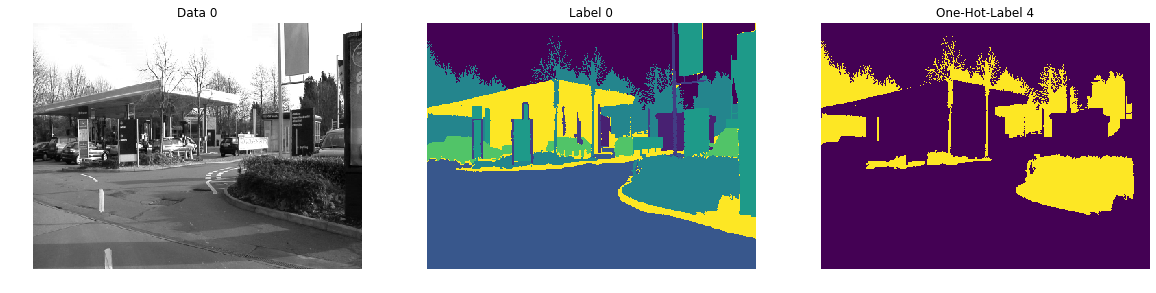

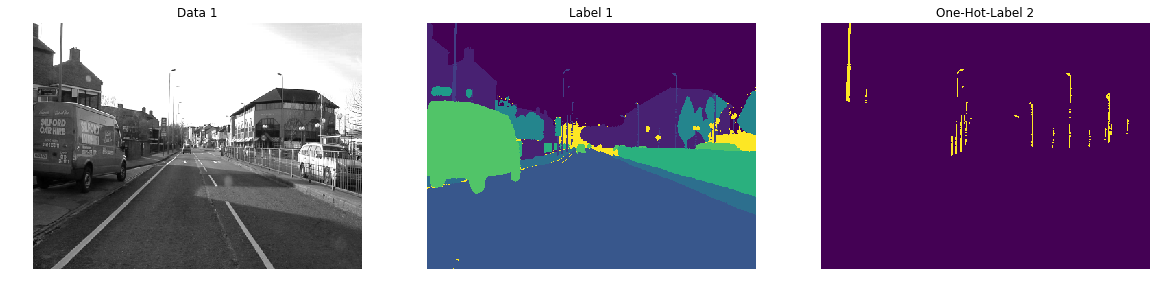

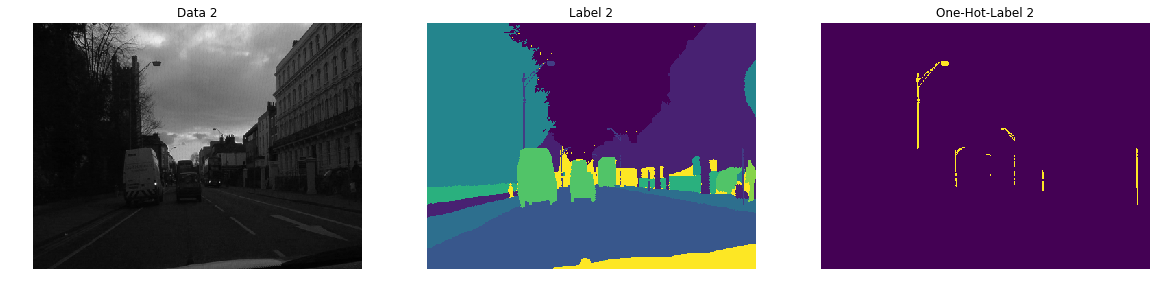

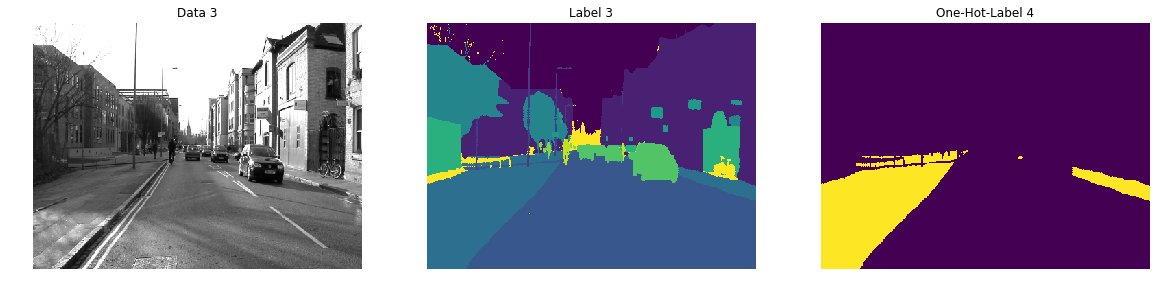

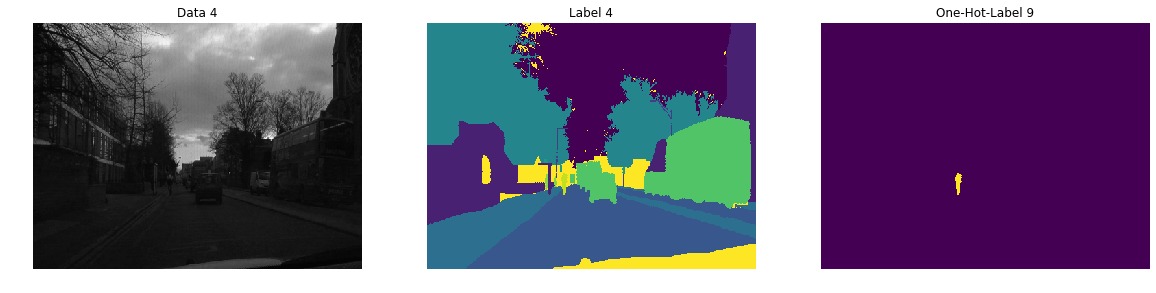

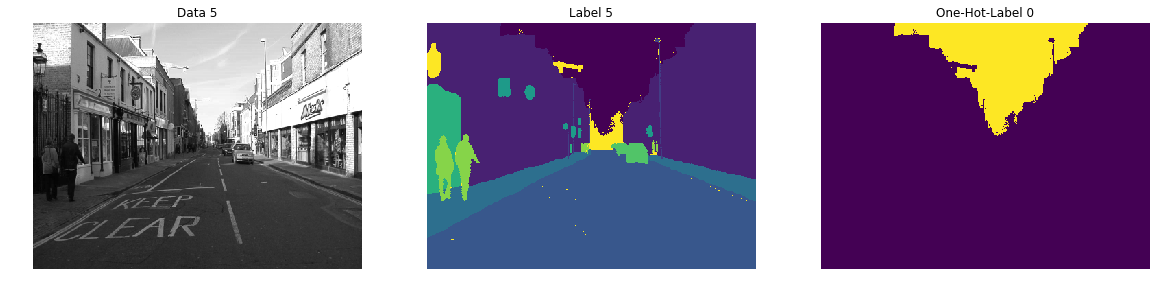

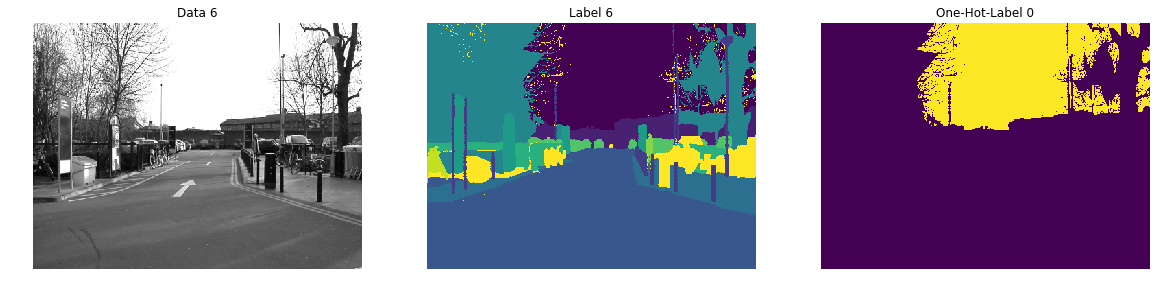

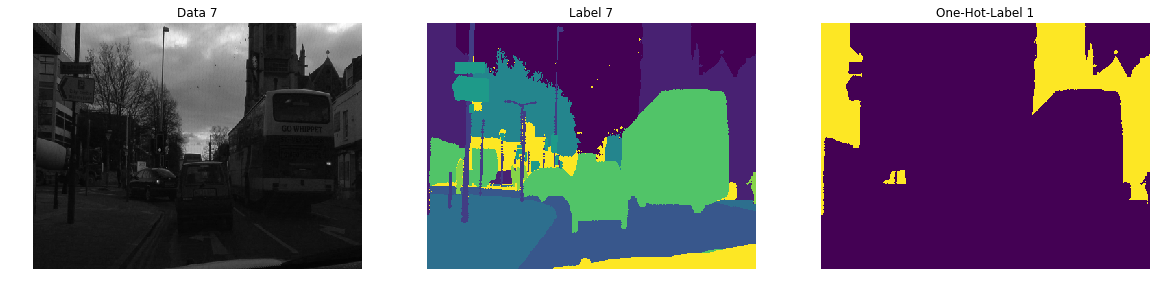

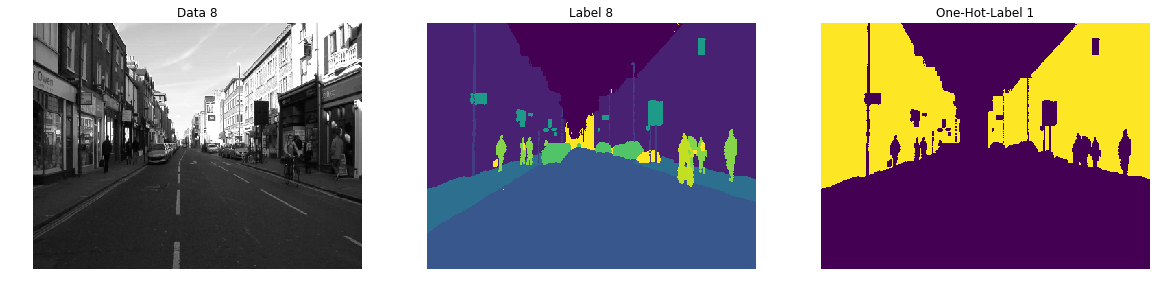

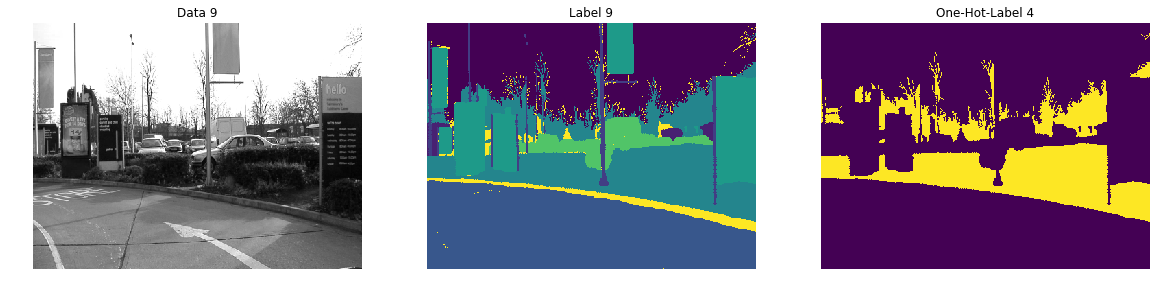

In [9]:
for i in range(images.size()[0]):

    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    plt.title(f'Data {i}')
    plt.axis('off')
    plt.imshow(images[i,0], cmap='gray')

    plt.subplot(1,3,2)
    plt.imshow(labels[i,0])
    plt.title(f'Label {i}')
    plt.axis('off')
    
    # create one-hot-encoding
    labels_ = labels[i,0]    
    
    h, w = labels_.size()
    map_classes = np.unique(labels_)
    num_classes = len(map_classes)
    
    targets = torch.zeros(num_classes, h, w)
    for c in range(num_classes):
        targets[c][labels_ == map_classes[c]] = 1
    
    c = random.randint(0,num_classes-1)
    
    plt.subplot(1,3,3)
    plt.imshow(targets[c])
    plt.title(f'One-Hot-Label {c}')
    plt.axis('off')
    plt.show()

---